In [1]:
from copy import deepcopy 

import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm 

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

from SmithZero import D2torchEngine

In [2]:
torch.manual_seed(42)

## Data Preparation 

In [3]:
from torchvision.datasets import CIFAR10 
import torchvision.transforms as T


# === data transformation === # 
train_T = T.Compose([   T.RandomCrop(32, padding=4),
                        T.RandomHorizontalFlip(), 
                        T.ToTensor(), 
                        T.Normalize(mean= (0.4914, 0.4822, 0.4465),
                                    std=(0.2023, 0.1994, 0.2010)),
                    ])

test_T = T.Compose([T.ToTensor(),
                    T.Normalize(mean=(0.4914, 0.4822, 0.4465),
                                std=(0.2023, 0.1994, 0.2010))
                    ])                  


# === download dataset object === # 
train_data = CIFAR10 (  root="./dataset/train",
                        train=True,
                        download=True,
                        transform=train_T )

test_data = CIFAR10 (   root="./dataset/test",
                        train=False,
                        download=True, 
                        transform=test_T ) 

Files already downloaded and verified
Files already downloaded and verified


## Data Batching 

In [4]:
from torch.utils.data import DataLoader

trainloader = DataLoader(train_data,
                        batch_size=124,
                        shuffle=True, 
                        num_workers=4 
                        )

testloader = DataLoader(test_data,
                        batch_size=124,
                        num_workers=4
                        )

## Model Design

In [5]:
class LeNet(nn.Module):
    def __init__(self, in_channels=3, n_class=10, p=0.5):
        super(LeNet, self).__init__()
        self.p = p # probability for DropOut layer 
        
        # === Create the convolution layers === # 
        self.c1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, padding=2)
        self.c3 = nn.Conv2d(6, 16, 5) 
        self.c5 = nn.Conv2d(16, 120, 5) 

        # === Create the linear layers === # 
        self.f6 = nn.Linear(in_features=480, out_features=84)
        self.output = nn.Linear(in_features=84, out_features=n_class)

        # === Create dropout layers === # 
        self.drop = nn.Dropout(self.p)

    def featurizer(self, x):
        # === block1 === # 
        x = self.c1(x)
        x = F.relu(x) 
        x = F.max_pool2d(x, kernel_size=2)
        # === block2 === # 
        x = self.c3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # === block3 === # 
        x = self.c5(x)
        x = F.relu(x)
        # ==== flattening === #
        x = nn.Flatten()(x)
        return x 

    def classifier(self, x): 
        # === hidden layler === # 
        if self.p > 0: 
            x = self.drop(x)        
        x = self.f6(x)
        x = F.relu(x)

        # === output layer === # 
        if self.p > 0 :
            x = self.drop(x)
        x = self.output(x)
        return x 
    
    def forward(self, x):
        x = self.featurizer(x) # return (1, 480)
        x = self.classifier(x) # return (1, 10)
        return x 

## W&B setup

In [6]:
# === hyperparameter dict === # 
# you can receive with .yaml or .json 

hyperparams = dict(
        seed=42, 
        epochs=50,
        classes=10,
        batch_size=128,
        n_workers=4,
        learning_rate=1e-3,
        dropout_p = 0.5,
        dataset="CIFAR10",
        architecture="LeNet")

In [7]:
import wandb 

wandb.login() 

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: doranlyong (use `wandb login --relogin` to force relogin)


True

In [8]:
proj_name = "LeNet-cifar10"

wandb.init(project=proj_name, config=hyperparams)
config = wandb.config 

/home/milky/anaconda3/envs/py38/lib/python3.8/site-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


## Model Configuration

In [9]:
model = LeNet(in_channels=3, n_class=config.classes, p=config.dropout_p)

loss_fn = nn.CrossEntropyLoss(reduction='mean') 
optimizer = optim.Adam( model.parameters(), # (!) be sure to pass in the model.parameters() 
                        lr=config.learning_rate, 
                    ) 

In [10]:
AgentDL = D2torchEngine(model, loss_fn, optimizer)

AgentDL.set_loaders(trainloader, testloader)
AgentDL.set_wandb(wandb)

100%|██████████| 100/100 [00:00<00:00, 108.85it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.34E-03


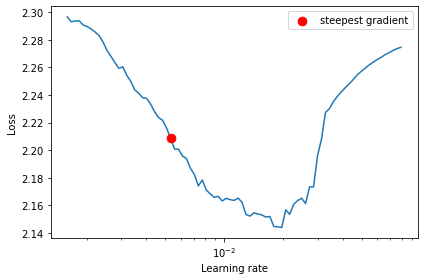

In [11]:
# === Learning Rate Range Test === # 
fig = AgentDL.lr_range_test(end_lr=1e-1, num_iter=100)

In [12]:
# === reset the optimzier === # 
reset_optimizer = optim.Adam(  model.parameters(), lr=5e-3) 
AgentDL.set_optimizer(reset_optimizer) 

## Set a scheduler 

In [13]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

scheduler = CosineAnnealingWarmRestarts(reset_optimizer, T_0=20, T_mult=4, eta_min=1e-5, last_epoch= -1, verbose=False)

AgentDL.set_lr_scheduler(scheduler)

In [14]:
AgentDL.optimizer == AgentDL.scheduler.optimizer

True

## Set gradient clipping 
* to handle ```exploding gradient```
* ```value_clipping```
* ```norm_clipping```

In [15]:
# https://stackoverflow.com/questions/34017866/arrow-on-a-line-plot-with-matplotlib
def add_arrow(line, position=None, direction='right', size=15, color=None, lw=2, alpha=1.0, text=None, text_offset=(0 , 0)):
    """
    add an arrow to a line.
    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color, lw=lw, linestyle='--' if alpha < 1 else '-', alpha=alpha),
        size=size,
    )
    if text is not None:
        line.axes.annotate(text, color=color,
            xytext=(xdata[end_ind] + text_offset[0], ydata[end_ind] + text_offset[1]),
            xy=(xdata[end_ind], ydata[end_ind]),
            size=size,
        )

def make_line(ax, point):
    point = np.vstack([[0., 0.], np.array(point.squeeze().tolist())])
    line = ax.plot(*point.T, lw=0)[0]
    return line        


def compare_grads(grads_before, grads_after):
    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    ax.set_xlim([0, 3])
    ax.set_ylim([0, 1.5])
    ax.set_xlabel('Parameter 0')
    ax.set_ylabel('Parameter 1')
    ax.set_title('Gradients')
    add_arrow(make_line(ax, grads_before), lw=2, color='k', text=r'$grad$', 
                size=12, alpha=1.0, text_offset=(-.13, .03))
    add_arrow(make_line(ax, grads_after), lw=2, color='r', text=r'$clipped\ grad$', 
                size=12, alpha=1.0, text_offset=(-.33, .03))
    fig.tight_layout()
    return fig

In [16]:
# === example gradient === # 
parm = nn.Parameter(torch.randn(2, 1))
fake_grads = torch.tensor([[2.5], [0.8]])


parm.grad = fake_grads.clone() 
print(f"model gradient: {parm.grad}")

model gradient: tensor([[2.5000],
        [0.8000]])


### Value clipping 

In [17]:
# === gradient value clipping === # 
nn.utils.clip_grad_value_(parm, clip_value=1.0)  # set maximum as 1.0

print(f"clipped gradient: {parm.grad}")

clipped gradient: tensor([[1.0000],
        [0.8000]])


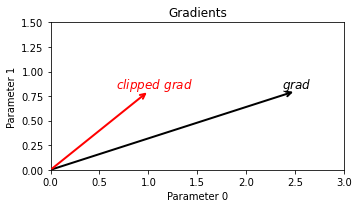

In [18]:
fig = compare_grads(fake_grads, parm.grad)

### Norm clipping 
* vector normalization 

In [19]:
parm.grad = fake_grads.clone()

# === gradient norm clipping === # 
nn.utils.clip_grad_norm_(parm, max_norm=1.0, norm_type=2)

print(fake_grads)
print(fake_grads.norm())

print(parm.grad)     
print(parm.grad.norm()) # 2.5/2.6249 := 0.9524
                        # 0.8/2.6249 := 0.3048

tensor([[2.5000],
        [0.8000]])
tensor(2.6249)
tensor([[0.9524],
        [0.3048]])
tensor(1.0000)


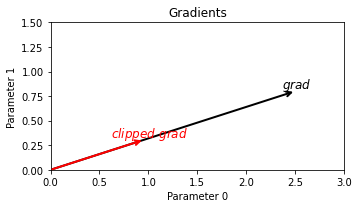

In [20]:
fig = compare_grads(fake_grads, parm.grad)  # normalized vector 

### apply gradient clipping in practice 

In [21]:
setattr(D2torchEngine, 'clipping', None) # add member variable 


def set_clip_grad_value(self, clip_value=1.0): 
    # *** gradient value clipping *** # 
    self.clipping = lambda: nn.utils.clip_grad_value_(self.model.parameters(), clip_value=clip_value)


def set_clip_grad_norm(self, max_norm=1.0, norm_type=2):
    # *** gradient norm clipping *** # 
    self.clipping = lambda: nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=max_norm, norm_type=norm_type)


setattr(D2torchEngine, 'set_clip_grad_value', set_clip_grad_value)    
setattr(D2torchEngine, 'set_clip_grad_norm', set_clip_grad_norm)    

In [22]:
# === Modifying traing_step === # 

def _make_train_step(self): 
    # === build this in higher-order function === # 
    def perform_train_step(input, label):
        self.model.train()  # set train mode 

        yhat = self.model(input) # get score out of the model 
        loss = self.loss_fn(yhat, label) # computes the loss 

        loss.backward() # computes gradients 
        
        if callable(self.clipping): # make sure gradient clipping 
            self.clipping()         # after computing gradients 

        # Updates parameters using gradients and the learning rate 
        self.optimizer.step() 
        self.optimizer.zero_grad() 
        
        # Returns the loss 
        return loss.item() 
    return perform_train_step

setattr(D2torchEngine, '_make_train_step', _make_train_step)        

The ```gradient clipping``` methods above work just fine for most models, <br/>
but they are of ```little use``` for ```recurrent neural networks```(RNN) (we’ll discuss them in Chapter 8) <br/>

In this case, we need to make gradients to be clipped ```during backpropagation``` like below:

### the backward hooks code to accomplish that:

In [23]:
def set_clip_backprop(self, clip_value=1.0): 
    # *** clipping during backpropagation *** # 

    if self.clipping is None: 
        self.clipping = []
    
    for parm in self.model.parameters():
        if parm.requires_grad:
            func = lambda grad: torch.clamp(grad, -clip_value, clip_value)
            handle = parm.register_hook(func)
            self.clipping.append(handle)

def remove_clip(self):
    # === Reset === # 
    # *** for the clip_backprop *** # 
    if isinstance(self.clipping, list):
        for handle in self.clipping:
            handle.remove()
    # *** for the clip_grad_value/norm *** #             
    self.clipping = None     


setattr(D2torchEngine, 'set_clip_backprop', set_clip_backprop)    
setattr(D2torchEngine, 'remove_clip', remove_clip)    

## Model Training 

In [24]:
AgentDL.set_clip_grad_value(clip_value=1.0) # make sure no gradients are ever above 1.0
#AgentDL.set_clip_backprop(clip_value=1.0) # clipping with hooks 


AgentDL.train(n_epochs=100, seed=config.seed)

100%|██████████| 100/100 [07:55<00:00,  4.75s/it]


In [25]:
AgentDL.remove_clip() 

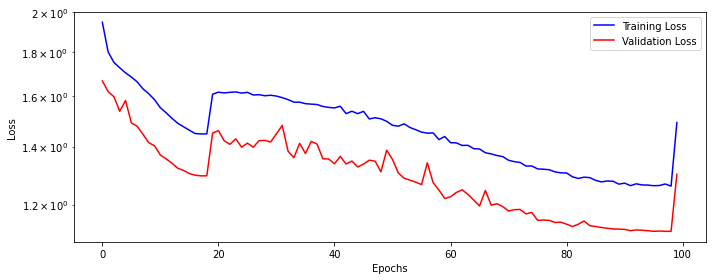

In [26]:
fig = AgentDL.plot_losses()

## Save Checkpointing 

In [30]:
AgentDL.save_checkpoint('model_checkpoint.pth')